<a href="https://colab.research.google.com/github/mojtabaSefidi/DataScience-SmallProjects/blob/master/AI_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import os 
import cv2 
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout, Flatten, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

# disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [6]:
!gdown http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xzvf lfw.tgz

Downloading...
From: http://vis-www.cs.umass.edu/lfw/lfw.tgz
To: /content/lfw.tgz
100% 181M/181M [00:03<00:00, 52.2MB/s]


In [79]:
data_slice = [70, 195, 78, 172] 
resize_ratio = 2.5

h = int((data_slice[1] - data_slice[0])/resize_ratio)
w = int((data_slice[3] - data_slice[2])/resize_ratio) 
print("Image dimension after resize (h,w) :", h, w)

Image dimension after resize (h,w) : 50 37


In [80]:
dataset_folder = "lfw"
sample_class = 100
class_name = []

for folder in os.listdir(dataset_folder):
    if len(os.listdir(os.path.join(dataset_folder, folder))) >= sample_class:
        class_name.append(folder)

In [82]:
imgs = []
labels = []

for folder in class_name:
    folder_files = os.listdir(os.path.join(dataset_folder, folder))
    len_sub_folder = len(folder_files) - 1
    for i, filename in enumerate(folder_files):
        img = cv2.imread(os.path.join(dataset_folder, folder, filename))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        croped = gray[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
        resized = cv2.resize(croped, (w,h))
        imgs.append(resized)
        labels.append(folder)

In [107]:
print(imgs[0].shape)
imgs[0]

(50, 37)


array([[126, 134, 121, ...,  14,  15,  21],
       [110, 107,  88, ...,  38,  24,  16],
       [104,  87,  66, ...,  99,  62,  23],
       ...,
       [ 32,  27,  21, ...,  96, 100, 107],
       [ 31,  29,  28, ..., 102, 105, 112],
       [ 31,  31,  28, ..., 111, 115, 118]], dtype=uint8)

In [110]:
labels[0]

'Gerhard_Schroeder'

In [83]:
print("Number of samples \t: ", len(labels))
print("Number of class \t: ", len(class_name))
print("Class name \t\t: \n", class_name)

Number of samples 	:  1140
Number of class 	:  5
Class name 		: 
 ['Gerhard_Schroeder', 'Colin_Powell', 'George_W_Bush', 'Donald_Rumsfeld', 'Tony_Blair']


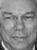

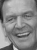

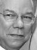

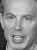

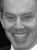

In [87]:
from google.colab.patches import cv2_imshow
cv2_imshow(imgs[300])
cv2_imshow(imgs[100])
cv2_imshow(imgs[200])
cv2_imshow(imgs[1000])
cv2_imshow(imgs[1100])

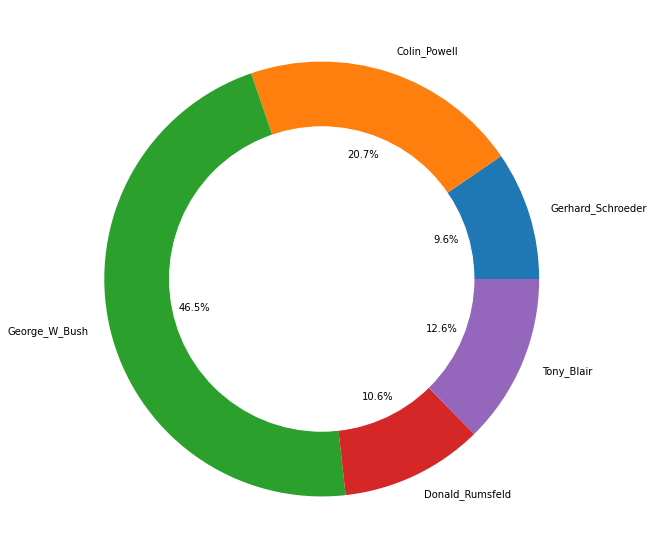

In [89]:
def print_data(label_distr, label_name):
    plt.figure(figsize=(10,10))

    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, 
            labels=label_name,  
            autopct='%1.1f%%')

    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()
    
label_distr = {i:labels.count(i) for i in labels}.values()
print_data(label_distr, class_name)

In [90]:
n = sample_class
def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)
mask = np.hstack([randc(labels, l) for l in np.unique(labels)])

balanced_labels = [labels[m] for m in mask]
balanced_imgs = [imgs[m] for m in mask]

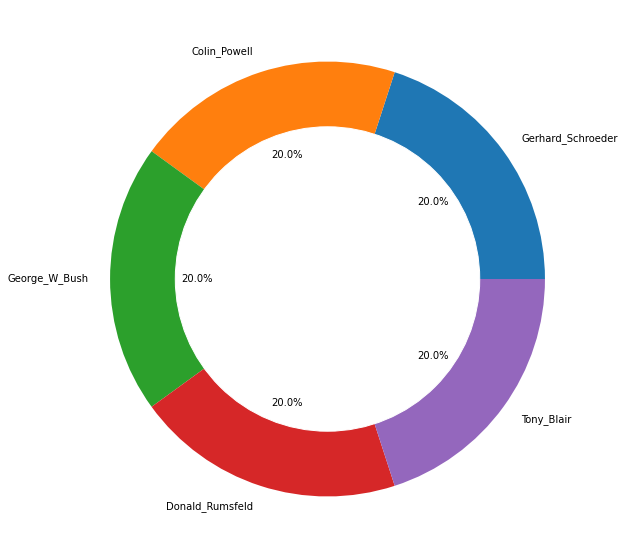

In [91]:
label_distr = {i:balanced_labels.count(i) for i in balanced_labels}.values()
print_data(label_distr, class_name)

In [92]:
le = LabelEncoder()
le.fit(balanced_labels)
le.classes_

array(['Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush',
       'Gerhard_Schroeder', 'Tony_Blair'], dtype='<U17')

In [93]:
X = np.array(balanced_imgs)
Y = le.transform(balanced_labels)
Y = to_categorical(Y)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
  
print("Dimension :")
print("X train \t X test \t Y train \t Y test")  
print("%s \t %s \t %s \t %s" % (X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Dimension :
X train 	 X test 	 Y train 	 Y test
(375, 50, 37) 	 (125, 50, 37) 	 (375, 5) 	 (125, 5)


In [95]:
def resize_data(X_train, X_test):
    if K.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
        input_shape = (1, X_train.shape[1], X_train.shape[2])
    else:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
        input_shape = (X_train.shape[1], X_train.shape[2], 1)
    return X_train, X_test, input_shape 

In [96]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [97]:
def cnn_model(image_shape, output_size):
    
    model = Sequential()
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=image_shape))
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
              
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dropout(0.2))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(output_size))
    model.add(Activation("softmax"))
    
    model.summary() 
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy', precision, recall])

    return model

In [98]:
X_train, X_test, input_shape = resize_data(X_train, X_test)
model = cnn_model(input_shape, len(class_name))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 35, 64)        640       
                                                                 
 conv2d_13 (Conv2D)          (None, 46, 33, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 23, 16, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 21, 14, 128)       73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 19, 12, 128)       147584    
                                                      

In [100]:
EPOCHS = 40
BATCH_SIZE = 64

callbacks = [EarlyStopping(monitor='val_loss', patience=6),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
history = model.fit(X_train, 
                      y_train,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      callbacks=callbacks,
                      validation_data=(X_test,y_test))

model.load_weights('best_model.h5')

Epoch 1/40
6/6 [==============================] - 8s 1s/step - loss: 1.6132 - accuracy: 0.2293 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6077 - val_accuracy: 0.2160 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
6/6 [==============================] - 8s 1s/step - loss: 1.6334 - accuracy: 0.1973 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6052 - val_accuracy: 0.2000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
6/6 [==============================] - 8s 1s/step - loss: 1.6331 - accuracy: 0.1813 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5989 - val_accuracy: 0.2720 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
6/6 [==============================] - 8s 1s/step - loss: 1.6192 - accuracy: 0.1947 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6095 - val_accuracy: 0.2000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
6/6 [==============================] - 7s 1s/step

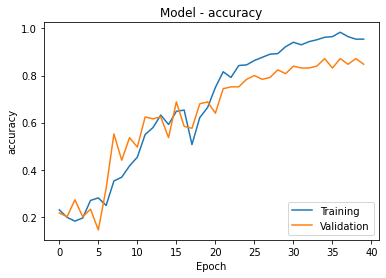

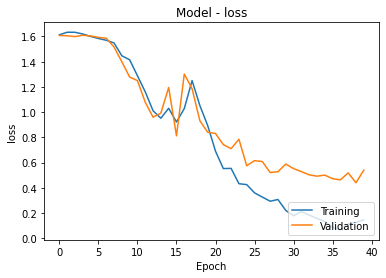

In [101]:
def evaluate_Accuracy(history):
    names = [['accuracy', 'val_accuracy'], 
             ['loss', 'val_loss']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.show()
        
evaluate_Accuracy(history)

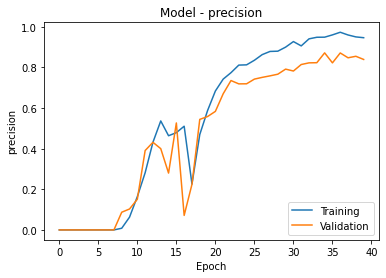

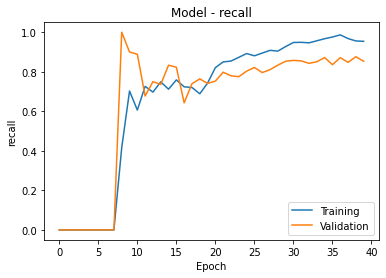

In [102]:
def evaluate_model(history):
    names = [['precision', 'val_precision'], 
             ['recall', 'val_recall']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.show()
        
evaluate_model(history)

In [103]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(7, 7))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

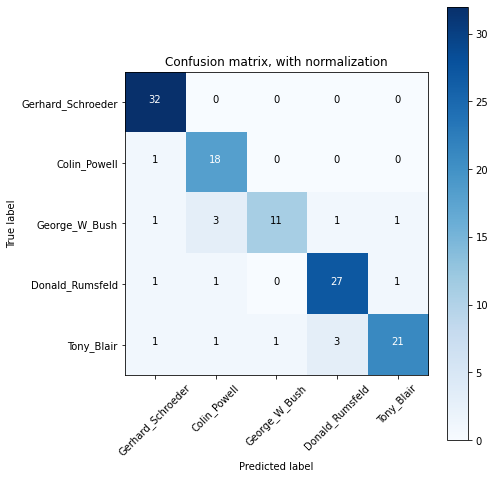

In [104]:
y_pred=model.predict(X_test)

cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, 
                      classes=class_name,
                      normalize=False,
                      title='Confusion matrix, with normalization')

In [105]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=class_name))

                   precision    recall  f1-score   support

Gerhard_Schroeder       0.89      1.00      0.94        32
     Colin_Powell       0.78      0.95      0.86        19
    George_W_Bush       0.92      0.65      0.76        17
  Donald_Rumsfeld       0.87      0.90      0.89        30
       Tony_Blair       0.91      0.78      0.84        27

         accuracy                           0.87       125
        macro avg       0.87      0.85      0.86       125
     weighted avg       0.88      0.87      0.87       125

